# Detecting Malicious URLs
## Baseline Experiments
### Understand Data
### Evaluate Some Traditional ML Algorithms

<a href="https://colab.research.google.com/github/rambasnet/DeepLearningMaliciousURLs/blob/master/Baseline-Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.utils.multiclass import unique_labels

## Download datasets
- dataset is downloading from: https://www.unb.ca/cic/datasets/url-2016.html
- if zip dataset files already exists; no download is done
- force unzip all the .zip files

In [4]:
%%bash
URL=https://iscxdownloads.cs.unb.ca/iscxdownloads/ISCX-URL-2016/
FILES=(ISCXURL2016.zip) 
for FILE in ${FILES[*]}; do
    if [ ! -f "$FILE" ]; then
        printf "downloading %s\n" $FILE
        curl -O $URL$FILE
        # unzip files
        echo 'unzipping ' $FILE
        unzip -o $FILE #overwrite exiting files/folders if exists
    fi
done

## Check CSV files inside FinalDataset folder

In [5]:
! ls FinalDataset

All.csv                      Malware_Infogain_test.csv
All.csv.pickle               Phishing.csv
All_BestFirst.csv            Phishing_BestFirst.csv
All_BestFirst_test.csv       Phishing_Infogain.csv
All_Infogain.csv             Phishing_Infogain_test.csv
All_Infogain_test.csv        Spam.csv
Defacement.csv               Spam_BestFirst.csv
Defacement_BestFirst.csv     Spam_BestFirst_test.csv
Defacement_Infogain.csv      Spam_Infogain.csv
Defacement_Infogain_test.csv Spam_Infogain_test.csv
Malware.csv                  URL
Malware_BestFirst.csv        models
Malware_Infogain.csv


## Load Dataset - FinalDataset/All.csv
- directly load small small (up to few GB) datasets
- large datasets (too big to fit in memory) may need to be handled differently
    1. allocate more memory or use computer with more memory
        - AWS and other cloud providers
    - work with a smaller sample
    - change data format (binary compact format, convert int to short and double to float)
    - use on-line learning technique by streaming or progressively loading data to train
    - use relational database (SQLite, MySQL or Postgres)
    - use big data platform (e.g. Hadoop, Spark, etc.)

In [6]:
# load dataset as Pandas Dataframe
df = pd.read_csv('FinalDataset/All.csv', low_memory=False)

## Summarize the Dataset
- check dimensions of the dataset
- peek at the data
- see the statistical summary of the attributes
- breakdown the data by the class

In [7]:
# dimension of the dataset
df.shape

(36707, 80)

In [8]:
# see all the attributes
df.columns

Index(['Querylength', 'domain_token_count', 'path_token_count',
       'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
       'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
       'ldl_filename', 'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path',
       'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
       'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
       'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
       'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
       'ISIpAddressInDomainName', 'CharacterContinuityRate',
       'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
       'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
       'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
       'Directory_LetterCount', 'Filename_LetterCount',
       'Extension_LetterCount', 'Query_LetterCount', 'LongestPathToken

In [9]:
# check data types
df.dtypes

Querylength                          int64
domain_token_count                   int64
path_token_count                     int64
avgdomaintokenlen                  float64
longdomaintokenlen                   int64
avgpathtokenlen                    float64
tld                                  int64
charcompvowels                       int64
charcompace                          int64
ldl_url                              int64
ldl_domain                           int64
ldl_path                             int64
ldl_filename                         int64
ldl_getArg                           int64
dld_url                              int64
dld_domain                           int64
dld_path                             int64
dld_filename                         int64
dld_getArg                           int64
urlLen                               int64
domainlength                         int64
pathLength                           int64
subDirLen                            int64
fileNameLen

### notice Notebook doesn't display all the rows and columns
- let's fix that

In [10]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [11]:
df.dtypes

Querylength                          int64
domain_token_count                   int64
path_token_count                     int64
avgdomaintokenlen                  float64
longdomaintokenlen                   int64
avgpathtokenlen                    float64
tld                                  int64
charcompvowels                       int64
charcompace                          int64
ldl_url                              int64
ldl_domain                           int64
ldl_path                             int64
ldl_filename                         int64
ldl_getArg                           int64
dld_url                              int64
dld_domain                           int64
dld_path                             int64
dld_filename                         int64
dld_getArg                           int64
urlLen                               int64
domainlength                         int64
pathLength                           int64
subDirLen                            int64
fileNameLen

### Notice that argPathRatio  type is object (string)
- we need to convert that to float when we cleanup data

In [12]:
# peek first 10 columns
df.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,ldl_domain,ldl_path,ldl_filename,ldl_getArg,dld_url,dld_domain,dld_path,dld_filename,dld_getArg,urlLen,domainlength,pathLength,subDirLen,fileNameLen,this.fileExtLen,ArgLen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,executable,isPortEighty,NumberofDotsinURL,ISIpAddressInDomainName,CharacterContinuityRate,LongestVariableValue,URL_DigitCount,host_DigitCount,Directory_DigitCount,File_name_DigitCount,Extension_DigitCount,Query_DigitCount,URL_Letter_Count,host_letter_count,Directory_LetterCount,Filename_LetterCount,Extension_LetterCount,Query_LetterCount,LongestPathTokenLength,Domain_LongestWordLength,Path_LongestWordLength,sub-Directory_LongestWordLength,Arguments_LongestWordLength,URL_sensitiveWord,URLQueries_variable,spcharUrl,delimeter_Domain,delimeter_path,delimeter_Count,NumberRate_URL,NumberRate_Domain,NumberRate_DirectoryName,NumberRate_FileName,NumberRate_Extension,NumberRate_AfterPath,SymbolCount_URL,SymbolCount_Domain,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,4,5,5.5,14,4.400000,4,8,3,0,0,0,0,0,0,0,0,0,0,58,25,26,26,13,1,2,0.448276,0.034483,0.08,0.431034,1.04,0.07692308,0,-1,5,-1,0.6,-1,1,0,0,0,1,-1,47,22,8,13,0,-1,13,14,13,5,-1,0,0,3,0,2,-1,0.017241,0.0,0.0,0.066667,1.0,-1.0,8,3,2,1,0,-1,0.726298,0.784493,0.894886,0.850608,NaN,-1.0,Defacement
1,0,4,5,5.5,14,6.000000,4,12,4,0,0,0,0,0,0,0,0,0,0,66,25,34,34,2,2,2,0.515151,0.030303,0.08,0.378788,1.36,0.05882353,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,56,22,8,13,9,-1,13,14,13,5,-1,0,0,4,0,1,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.688635,0.784493,0.814725,0.859793,0.0,-1.0,Defacement
2,0,4,5,5.5,14,5.800000,4,12,5,0,0,0,0,0,0,0,0,0,0,65,25,33,33,2,2,2,0.507692,0.030769,0.08,0.384615,1.32,0.060606062,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,55,22,8,13,8,-1,13,14,13,5,-1,0,0,4,0,1,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.695049,0.784493,0.814725,0.801880,0.0,-1.0,Defacement
3,0,4,12,5.5,14,5.500000,4,32,16,0,0,0,0,0,0,0,0,0,0,109,25,77,77,2,2,2,0.706422,0.018349,0.08,0.229358,3.08,0.025974026,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,92,22,8,13,45,-1,52,14,13,13,-1,0,0,4,0,8,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.640130,0.784493,0.814725,0.663210,0.0,-1.0,Defacement
4,0,4,6,5.5,14,7.333334,4,18,11,0,0,0,0,0,0,0,0,0,0,81,25,49,49,2,2,2,0.604938,0.024691,0.08,0.308642,1.96,0.040816326,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,70,22,8,13,23,-1,24,14,13,13,-1,0,0,4,0,2,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.681307,0.784493,0.814725,0.804526,0.0,-1.0,Defacement
5,0,4,8,5.5,14,6.500000,4,22,10,0,0,0,0,0,0,0,0,0,0,91,25,59,59,2,2,2,0.648352,0.021978,0.08,0.274725,2.36,0.033898305,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,78,22,8,13,31,-1,34,14,15,13,-1,0,0,4,0,4,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.666676,0.784493,0.814725,0.755658,0.0,-1.0,Defacement
6,0,4,5,5.5,14,7.800000,4,17,10,0,0,0,0,0,0,0,0,0,0,75,25,43,43,2,2,2,0.573333,0.026667,0.08,0.333333,1.72,0.046511628,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,65,22,8,13,18,-1,18,14,18,5,-1,0,0,4,0,1,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.682440,0.784493,0.814725,0.766719,0.0,-1.0,Defacement
7,0,4,7,5.5,14,6.285714,4,16,9,0,0,0,0,0,0,0,0,0,0,82,25,50,50,2,2,2,0.609756,0.024390,0.08,0.304878,2.00,0.04,0,-1,4,-1,0.6,-1,8,0,0,0,8,-1,62,22,8,13,15,-1,25,14,13,13,-1,0,0,4,0,3,-1,0.097561,0.0,0.0,0.320000,NaN,-1.0,8,3,3,0,0,-1,0.709396,0.784493,0.814725,0.797498,0.0,-1.0,Defacement
8,0,4,6,5.5,14,6.500000,4,16,10,0,0,0,0,0,0,0,0,0,0,76,25,44,44,2,2,2,0.578947,0.026316,0.08,0.328947,1.76,0.045454547,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,65,22,8,13,18,-1,19,14,13,13,-1,0,0,4,0,2,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.678242,0.784493,0.814725,0.732258,0.0,-1.0,Defacement
9,0,4,5

## Notice NumberRate_Extension has NaN values
- there may be more samples with NaN values for more attributes

In [13]:
# peek last 5 columns
df.tail()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,ldl_domain,ldl_path,ldl_filename,ldl_getArg,dld_url,dld_domain,dld_path,dld_filename,dld_getArg,urlLen,domainlength,pathLength,subDirLen,fileNameLen,this.fileExtLen,ArgLen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,executable,isPortEighty,NumberofDotsinURL,ISIpAddressInDomainName,CharacterContinuityRate,LongestVariableValue,URL_DigitCount,host_DigitCount,Directory_DigitCount,File_name_DigitCount,Extension_DigitCount,Query_DigitCount,URL_Letter_Count,host_letter_count,Directory_LetterCount,Filename_LetterCount,Extension_LetterCount,Query_LetterCount,LongestPathTokenLength,Domain_LongestWordLength,Path_LongestWordLength,sub-Directory_LongestWordLength,Arguments_LongestWordLength,URL_sensitiveWord,URLQueries_variable,spcharUrl,delimeter_Domain,delimeter_path,delimeter_Count,NumberRate_URL,NumberRate_Domain,NumberRate_DirectoryName,NumberRate_FileName,NumberRate_Extension,NumberRate_AfterPath,SymbolCount_URL,SymbolCount_Domain,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
36702,29,4,14,5.750000,12,3.666667,4,20,24,3,0,3,0,2,0,0,0,0,0,146,26,113,113,2,2,85,0.773973,0.582192,3.269231,0.178082,4.346154,0.7522124,0,-1,5,-1,0.500000,23,31,0,4,0,27,3,94,23,46,7,14,24,43,12,11,11,23,0,3,6,0,2,5,0.212329,0.0,0.064516,0.529412,0.627907,0.066667,19,3,11,3,2,7,0.690555,0.791265,0.777498,0.690227,0.656684,0.796205,spam
36703,0,4,13,3.750000,8,8.461538,4,24,23,0,0,0,0,0,0,0,0,0,0,147,18,122,122,2,2,2,0.829932,0.013605,0.111111,0.122449,6.777778,0.016393442,0,-1,5,-1,0.500000,-1,21,0,0,0,21,-1,101,15,7,6,69,-1,105,8,9,9,-1,0,0,3,0,2,-1,0.142857,0.0,0.000000,0.187500,0.200000,-1.000000,23,3,2,16,15,-1,0.665492,0.820010,0.879588,0.674400,0.674671,-1.000000,spam
36704,58,3,27,6.666666,16,3.375000,3,41,34,20,0,20,0,18,12,0,12,0,12,246,22,217,217,2,2,182,0.882114,0.739837,8.272727,0.089431,9.863636,0.83870965,0,-1,7,-1,0.772727,58,57,0,6,0,51,1,156,20,71,3,58,48,118,16,12,12,0,0,1,12,0,9,1,0.231707,0.0,0.073171,0.377778,0.418033,0.029412,26,2,14,8,7,9,0.656807,0.801139,0.684777,0.713622,0.717187,0.705245,spam
36705,35,3,13,4.333334,9,3.600000,3,15,13,7,0,7,0,7,4,0,4,0,4,116,15,94,94,2,2,71,0.810345,0.612069,4.733333,0.129310,6.266667,0.7553192,0,-1,3,-1,0.666667,32,25,0,0,0,25,23,73,13,4,11,41,12,75,9,8,8,0,0,2,3,0,3,3,0.215517,0.0,0.000000,0.284091,0.333333,0.418182,14,2,1,9,8,3,0.725963,0.897617,0.871049,0.745932,0.758824,0.790772,spam
36706,40,3,25,6.666666,16,3.250000,3,35,31,19,0,19,0,17,6,0,6,0,6,227,22,198,198,2,2,164,0.872247,0.722467,7.454546,0.096916,9.000000,0.82828283,0,-1,6,-1,0.772727,40,52,0,6,1,45,2,144,20,50,6,64,31,118,16,10,10,0,0,1,11,0,8,1,0.229075,0.0,0.083333,0.365079,0.381356,0.060000,24,2,13,7,6,7,0.674351,0.801139,0.697282,0.730563,0.731481,0.769238,spam


In [14]:
# statistical summary
print(df.describe())

        Querylength  domain_token_count  path_token_count  avgdomaintokenlen  \
count  36707.000000        36707.000000      36707.000000       36707.000000   
mean      21.908110            2.857439          8.954668           5.401719   
std       94.280669            0.906562          4.278406           1.986858   
min        0.000000            2.000000          0.000000           1.500000   
25%        0.000000            2.000000          6.000000           4.000000   
50%        0.000000            3.000000          8.000000           5.000000   
75%       19.000000            3.000000         11.000000           6.500000   
max     1385.000000           19.000000         68.000000          29.500000   

       longdomaintokenlen  avgpathtokenlen           tld  charcompvowels  \
count        36707.000000     36427.000000  36707.000000    36707.000000   
mean             9.746016         4.556261      2.857439       14.976517   
std              4.856580         2.839388      0.9

In [15]:
#df.astype({'argPathRatio': 'float'})
df['argPathRatio'] = df['argPathRatio'].astype('float')

In [16]:
# check attibute types
df.dtypes

Querylength                          int64
domain_token_count                   int64
path_token_count                     int64
avgdomaintokenlen                  float64
longdomaintokenlen                   int64
avgpathtokenlen                    float64
tld                                  int64
charcompvowels                       int64
charcompace                          int64
ldl_url                              int64
ldl_domain                           int64
ldl_path                             int64
ldl_filename                         int64
ldl_getArg                           int64
dld_url                              int64
dld_domain                           int64
dld_path                             int64
dld_filename                         int64
dld_getArg                           int64
urlLen                               int64
domainlength                         int64
pathLength                           int64
subDirLen                            int64
fileNameLen

In [17]:
# class distribution for original data
print(df.groupby('URL_Type_obf_Type').size())

URL_Type_obf_Type
Defacement    7930
benign        7781
malware       6712
phishing      7586
spam          6698
dtype: int64


In [18]:
# sample distribution print in markdown table format
label = 'URL_Type_obf_Type'
lblTypes = set(df[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df[df[label] == lbl].index)))

| spam | 6698 |
| phishing | 7586 |
| Defacement | 7930 |
| malware | 6712 |
| benign | 7781 |


## Clean Data
- strip whitespace from column names
- dropped samples/rows with Infinity values
- dropped samples/rows with NaN values
- convert argPathRatio attribute type to float

In [19]:
# function loads, cleans and returns panda dataframe
def loadAndCleanData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        #df.drop(columns=[], inplace=True)
        # drop missing values/NaN etc.
        #df.dropna(inplace=True)
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col] == 'Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            indexNames = df[df[col]== 'NaN'].index
            if not indexNames.empty:
                print('deleting {} rows with NaN in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
        df['argPathRatio'].astype('float')
        # drop NaN pandas way
        beforeRows = df.shape[0]
        df.dropna(inplace = True)
        print('Dropped {} rows with NaN values'.format(beforeRows - df.shape[0]))
        df.to_pickle(pickleDump)
        
    return df

In [20]:
df1 = loadAndCleanData('FinalDataset/All.csv')

In [21]:
# sample distribution print in markdown table format
label = 'URL_Type_obf_Type'
lblTypes = set(df1[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df1[df1[label] == lbl].index)))

| spam | 5342 |
| phishing | 4014 |
| Defacement | 2477 |
| malware | 4440 |
| benign | 2709 |


## Data Visualization
- works better for dataset with fewer features/attributes
- not suited for current dataset with 79 features

### Common visualizations
- Univariate Plots
    - helps understand each attribute using box and whisker plots
- Histogram Plots
    - helps understand the distribution (Gaussian distribution?) of each attribute
- Multivariate Plots
    - scatter plots of all pairs of attributes help understand the relationships between attributes

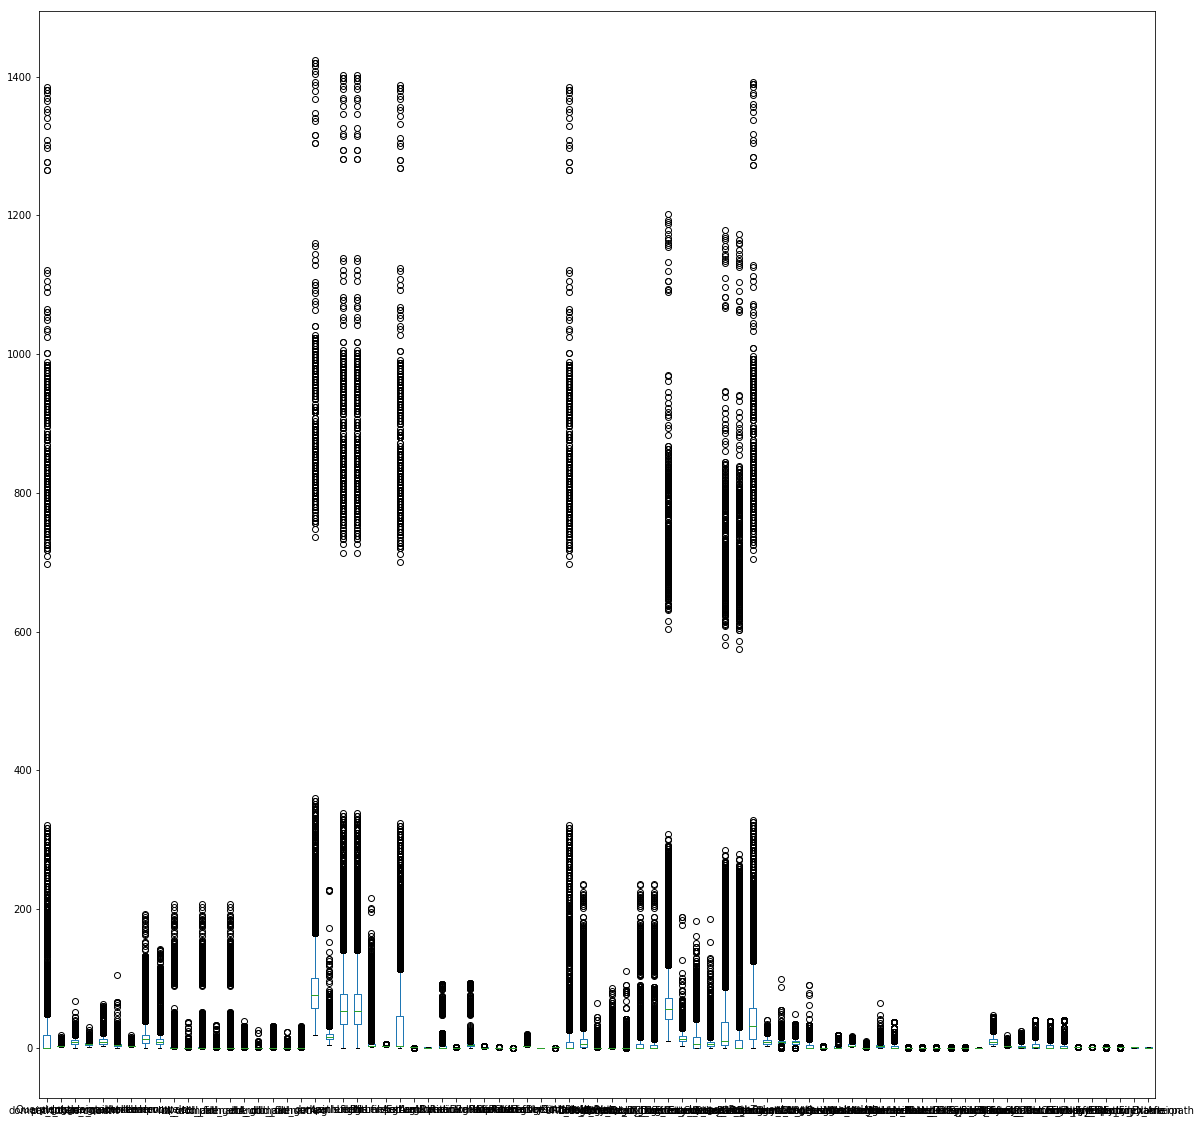

In [22]:
# unvariate plots
df.plot.box(figsize=(20,20))

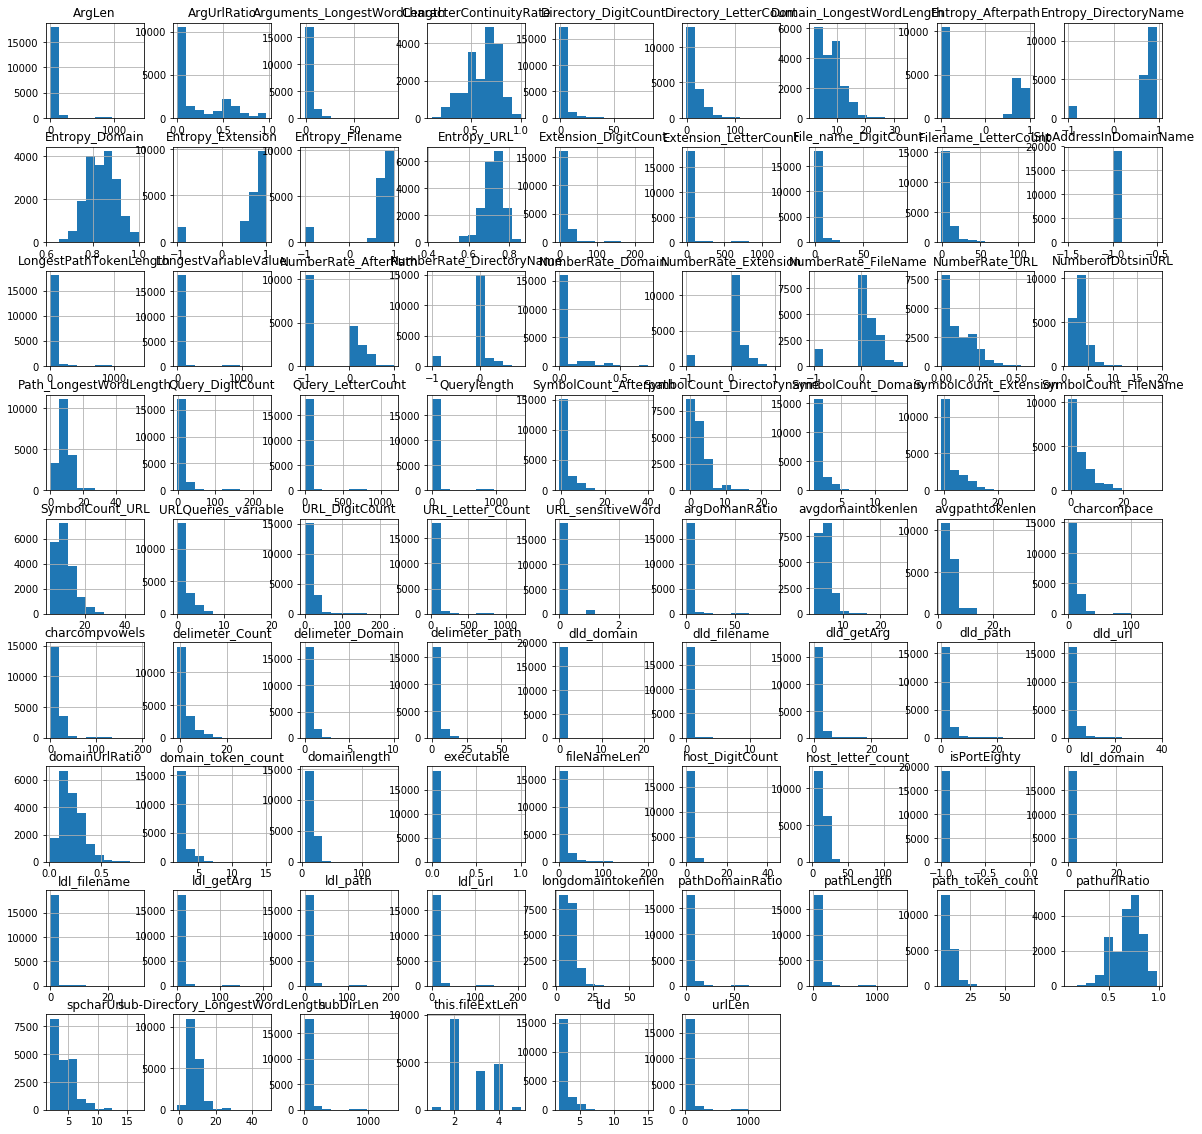

In [23]:
# Histograms of each attribute
df1.hist(figsize=(20, 20))
#plt.figure(figsize=(2, 1))
plt.show()

## Evaluate Traditional ML Algorithms
- create a baseline model from a bunch of traditional ML algorithms
    - separate out a validation dataset
    - set-up test harness to use 10-fold cross-validation
    - build models to classify samples into various URL types
    - select the best model as our baseline model

### Create a Validation Dataset
- will be used to test our model to see how good it is!
- use 80/20 split
- 80% of samples used for training and 20% held back for validation

In [24]:
# Split-out validation dataset
def splitDataset(df):
    array = df.values
    X = array[:,0:79]
    Y = array[:,79]
    validation_size = 0.20
    random_seed = 100
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, 
                                                                                    test_size=validation_size, 
                                                                                    random_state=random_seed)
    return X_train, X_validation, Y_train, Y_validation
    

## Build Models
- build and compare models from 9 traditional machine learning algorithms

## Evaluate Models
- use 10-fold cross validation to estimate accuracy results
- split out dataset into 10 parts, train on 9 and test on 1 and repeat for all combination of train-test splits
- calculate the average accuracy

In [29]:
def runExperiments(X_train, Y_train):
    random_seed = 100
    scoring = 'accuracy'
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='auto')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('AB', AdaBoostClassifier(n_estimators=100)))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier(n_estimators=10)))

    # evaluate each model in turn using 10-fold cross-validation
    results = []
    classifiers = []
    accuracies = []
    for classifier, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=random_seed)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        accuracies.append((cv_results.mean(), classifier))
        results.append(cv_results)
        classifiers.append(classifier)
        msg = "%s: %f (%f)" % (classifier, cv_results.mean(), cv_results.std())
        print(msg)
    return results, accuracies, classifiers

## Multi-class Classification

In [30]:
# NOTE: This takes some time...
X_train, X_validation, Y_train, Y_validation = splitDataset(df1)
results, accuracies, classifiers = runExperiments(X_train, Y_train)

LR: 0.865723 (0.005916)


/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.


LDA: 0.818438 (0.007342)
KNN: 0.908595 (0.006872)
CART: 0.939611 (0.005399)
NB: 0.622784 (0.020285)
SVM: 0.910439 (0.006137)
AB: 0.616538 (0.037306)
DT: 0.939414 (0.006758)
RF: 0.961343 (0.002088)


## Compare and Select Best Model
- Compare Algorithms using box-plot

In [31]:
def compareModels(accuracies, results, classifiers):
    # sort the mean accuracy results in descending order and print
    accuracies.sort(reverse=True)
    for acc, cls in accuracies:
        print("{} {:.2f}".format(cls, acc))
    # Compare Algorithms using box-plot
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(classifiers)
    plt.show()

RF 0.96
CART 0.94
DT 0.94
SVM 0.91
KNN 0.91
LR 0.87
LDA 0.82
NB 0.62
AB 0.62


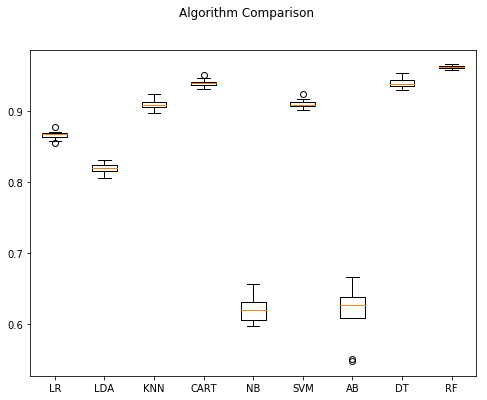

In [32]:
compareModels(accuracies, results, classifiers)

# Make Predictions using Random Forest (RF)
- RF provides superior accuracy result over all the classifiers
- now check the accuracy of the best model using validation set

In [33]:
def testBestModel(model, X_validation, Y_validation):
    # make predictions on validation dataset
    Y_predictions = rf.predict(X_validation)
    print("Accuracy = {:.2f}".format(accuracy_score(Y_validation, Y_predictions)))
    print('Confusion Matrix:')
    print(confusion_matrix(Y_validation, Y_predictions))
    print('Classification Report:')
    print(classification_report(Y_validation, Y_predictions))
    return Y_predictions

In [35]:
# train the best model and find the validation accuracy
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, Y_train)
Y_predictions = testBestModel(rf, X_validation, Y_validation)

Accuracy = 0.96
Confusion Matrix:
[[ 498    5    3   19    1]
 [   0  529    3   13    1]
 [   3    4  893   13    0]
 [  12   19   12  708   13]
 [   2    1    1   21 1023]]
Classification Report:
              precision    recall  f1-score   support

  Defacement       0.97      0.95      0.96       526
      benign       0.95      0.97      0.96       546
     malware       0.98      0.98      0.98       913
    phishing       0.91      0.93      0.92       764
        spam       0.99      0.98      0.98      1048

    accuracy                           0.96      3797
   macro avg       0.96      0.96      0.96      3797
weighted avg       0.96      0.96      0.96      3797



### Confusion Matrix Visualization

In [53]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


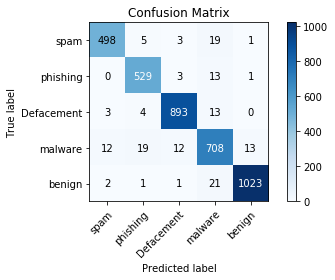

In [38]:
classes = lblTypes
np.set_printoptions(precision=2)
# plot non-normalized confusion matrix
plot_confusion_matrix(Y_validation, Y_predictions, classes=classes, 
                       title='Confusion Matrix')

## Binary-class classification
- Label spam, phishing, malware, defacement as 'malicious'
- Keep benign type as benign

In [39]:
lblTypes = list(lblTypes)
lblTypes

['spam', 'phishing', 'Defacement', 'malware', 'benign']

In [40]:
lblTypes = dict(zip(lblTypes, ['malicious']*5))
lblTypes['benign'] = 'benign'
lblTypes

{'spam': 'malicious',
 'phishing': 'malicious',
 'Defacement': 'malicious',
 'malware': 'malicious',
 'benign': 'benign'}

In [41]:
df1[label] = df1[label].map(lblTypes)

In [42]:
# class distribution for original data
print(df1.groupby('URL_Type_obf_Type').size())

URL_Type_obf_Type
benign        2709
malicious    16273
dtype: int64


In [43]:
df1.tail()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,ldl_domain,ldl_path,ldl_filename,ldl_getArg,dld_url,dld_domain,dld_path,dld_filename,dld_getArg,urlLen,domainlength,pathLength,subDirLen,fileNameLen,this.fileExtLen,ArgLen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,executable,isPortEighty,NumberofDotsinURL,ISIpAddressInDomainName,CharacterContinuityRate,LongestVariableValue,URL_DigitCount,host_DigitCount,Directory_DigitCount,File_name_DigitCount,Extension_DigitCount,Query_DigitCount,URL_Letter_Count,host_letter_count,Directory_LetterCount,Filename_LetterCount,Extension_LetterCount,Query_LetterCount,LongestPathTokenLength,Domain_LongestWordLength,Path_LongestWordLength,sub-Directory_LongestWordLength,Arguments_LongestWordLength,URL_sensitiveWord,URLQueries_variable,spcharUrl,delimeter_Domain,delimeter_path,delimeter_Count,NumberRate_URL,NumberRate_Domain,NumberRate_DirectoryName,NumberRate_FileName,NumberRate_Extension,NumberRate_AfterPath,SymbolCount_URL,SymbolCount_Domain,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
36702,29,4,14,5.750000,12,3.666667,4,20,24,3,0,3,0,2,0,0,0,0,0,146,26,113,113,2,2,85,0.773973,0.582192,3.269231,0.178082,4.346154,0.7522124,0,-1,5,-1,0.500000,23,31,0,4,0,27,3,94,23,46,7,14,24,43,12,11,11,23,0,3,6,0,2,5,0.212329,0.0,0.064516,0.529412,0.627907,0.066667,19,3,11,3,2,7,0.690555,0.791265,0.777498,0.690227,0.656684,0.796205,malicious
36703,0,4,13,3.750000,8,8.461538,4,24,23,0,0,0,0,0,0,0,0,0,0,147,18,122,122,2,2,2,0.829932,0.013605,0.111111,0.122449,6.777778,0.016393442,0,-1,5,-1,0.500000,-1,21,0,0,0,21,-1,101,15,7,6,69,-1,105,8,9,9,-1,0,0,3,0,2,-1,0.142857,0.0,0.000000,0.187500,0.200000,-1.000000,23,3,2,16,15,-1,0.665492,0.820010,0.879588,0.674400,0.674671,-1.000000,malicious
36704,58,3,27,6.666666,16,3.375000,3,41,34,20,0,20,0,18,12,0,12,0,12,246,22,217,217,2,2,182,0.882114,0.739837,8.272727,0.089431,9.863636,0.83870965,0,-1,7,-1,0.772727,58,57,0,6,0,51,1,156,20,71,3,58,48,118,16,12,12,0,0,1,12,0,9,1,0.231707,0.0,0.073171,0.377778,0.418033,0.029412,26,2,14,8,7,9,0.656807,0.801139,0.684777,0.713622,0.717187,0.705245,malicious
36705,35,3,13,4.333334,9,3.600000,3,15,13,7,0,7,0,7,4,0,4,0,4,116,15,94,94,2,2,71,0.810345,0.612069,4.733333,0.129310,6.266667,0.7553192,0,-1,3,-1,0.666667,32,25,0,0,0,25,23,73,13,4,11,41,12,75,9,8,8,0,0,2,3,0,3,3,0.215517,0.0,0.000000,0.284091,0.333333,0.418182,14,2,1,9,8,3,0.725963,0.897617,0.871049,0.745932,0.758824,0.790772,malicious
36706,40,3,25,6.666666,16,3.250000,3,35,31,19,0,19,0,17,6,0,6,0,6,227,22,198,198,2,2,164,0.872247,0.722467,7.454546,0.096916,9.000000,0.82828283,0,-1,6,-1,0.772727,40,52,0,6,1,45,2,144,20,50,6,64,31,118,16,10,10,0,0,1,11,0,8,1,0.229075,0.0,0.083333,0.365079,0.381356,0.060000,24,2,13,7,6,7,0.674351,0.801139,0.697282,0.730563,0.731481,0.769238,malicious


## Run Experiments to build Models

In [44]:
# NOTE: This takes a long time...
X_train, X_validation, Y_train, Y_validation = splitDataset(df1)
results, accuracies, classifiers = runExperiments(X_train, Y_train)

LR: 0.954363 (0.004980)


/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.


LDA: 0.928218 (0.005869)
KNN: 0.970234 (0.003176)
CART: 0.981561 (0.003881)
NB: 0.612648 (0.014896)
SVM: 0.954758 (0.005046)
AB: 0.979124 (0.003438)
DT: 0.981627 (0.003776)
RF: 0.987817 (0.002229)


## Compare and Select Best Model

RF 0.99
DT 0.98
CART 0.98
AB 0.98
KNN 0.97
SVM 0.95
LR 0.95
LDA 0.93
NB 0.61


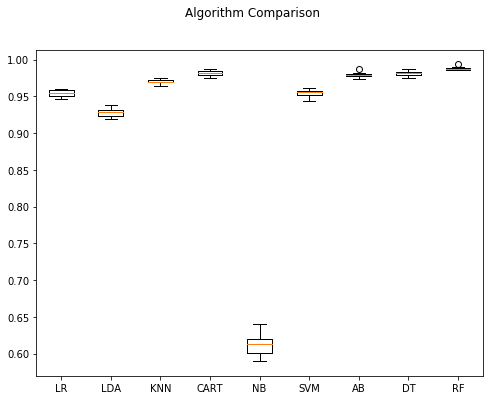

In [45]:
compareModels(accuracies, results, classifiers)

## Make Predictions using Best Classifier: Random Forest (RF)

In [47]:
# train the best model and find the validation accuracy
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, Y_train)
Y_predictions = testBestModel(rf, X_validation, Y_validation)

Accuracy = 0.99
Confusion Matrix:
[[ 534   12]
 [  26 3225]]
Classification Report:
              precision    recall  f1-score   support

      benign       0.95      0.98      0.97       546
   malicious       1.00      0.99      0.99      3251

    accuracy                           0.99      3797
   macro avg       0.97      0.99      0.98      3797
weighted avg       0.99      0.99      0.99      3797



### Confusion Matrix Viz

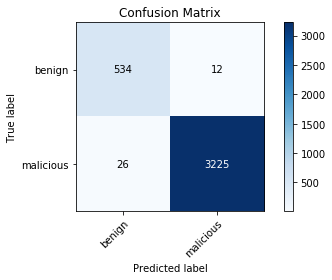

In [54]:
classes = ['benign', 'malicious']
np.set_printoptions(precision=2)
# plot non-normalized confusion matrix
plot_confusion_matrix(Y_validation, Y_predictions, classes=classes, 
                       title='Confusion Matrix')